### Importing Necessary Libraries

In [1]:
import os
import cv2
import tensorflow as tf
from typing import List
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Convolution3D,MaxPooling3D,Dense,Flatten,Bidirectional,LSTM,Dropout,TimeDistributed
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

### Functions for text and video Pre Processing

In [2]:
def load_video(path:str)->List[float]:
    cap=cv2.VideoCapture(path)
    frames=[]
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret,frame=cap.read()
        frame=tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
        # frames.append(frame[200:236,110:200,:])
    cap.release()
    # frames = tf.convert_to_tensor(frames, dtype=tf.float32)
    # normalized_frames = tf.image.per_image_standardization(frames)
    # return normalized_frames
    mean = tf.math.reduce_mean(frames)
    sd = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / sd

In [3]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [4]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [5]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f:
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [6]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    return frames, alignments

### Data Visualisation

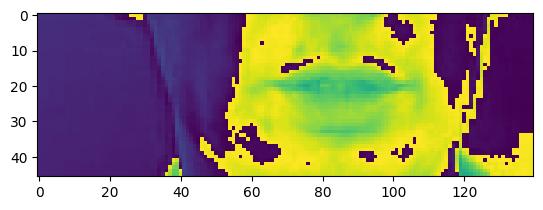

In [7]:
test_path = '.\\data\\s1\\bbal6n.mpg'
frames, alignments = load_data(tf.convert_to_tensor(test_path))
plt.imshow(frames[30])

In [8]:
# cap = cv2.VideoCapture(test_path)
# frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# for i in range(frame_count):
#     frame = frames[i].numpy()
#     plt.imshow(frame)
#     plt.show() 
#  cap.release()

In [9]:
alignments
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [10]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

### Train and Test Split

In [11]:
data=tf.data.Dataset.list_files('./data/s1/*mpg')
num_elements = tf.data.experimental.cardinality(data)
# print(f"Number of elements in the dataset: {num_elements.numpy()}")
data=data.shuffle(500,reshuffle_each_iteration=False)
data=data.map(mappable_function)
batch_size=2
data = data.padded_batch(batch_size, padded_shapes=([75,None,None,None],[40]))
#data = data.padded_batch(batch_size, padded_shapes=([75, None, None, None], [None]),padding_values=(0.0, tf.constant(-1, dtype=tf.int64)))
data = data.prefetch(tf.data.AUTOTUNE)
total_elements = num_elements.numpy()
train_size = int(0.7 * total_elements / batch_size)
train_data = data.take(train_size)
test_data = data.skip(train_size)
print(len(train_data),len(test_data))

350 150


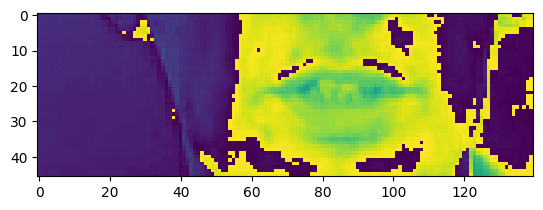

In [12]:
frames, alignments = data.as_numpy_iterator().next()
sample = data.as_numpy_iterator()
val = sample.next(); 
plt.imshow(val[0][0][33])

In [13]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue by z eight now'>

In [14]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

### Model Building

In [15]:
model=Sequential()
model.add(Convolution3D(128,3,input_shape=(75,46,140,1),padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(1,2,2)))
model.add(Convolution3D(256,3,padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(1,2,2)))
model.add(Convolution3D(75,3,padding="same",activation="relu"))
model.add(MaxPooling3D(pool_size=(1,2,2)))
model.add(TimeDistributed(Flatten()))
model.add(Bidirectional(LSTM(128,kernel_initializer="Orthogonal",return_sequences=True)))
model.add(Dropout(.5))
model.add(Bidirectional(LSTM(128,kernel_initializer="Orthogonal",return_sequences=True)))
model.add(Dropout(.5))
model.add(Dense(128,activation="relu"))
model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer="he_normal", activation="softmax"))
model.output_shape

(None, 75, 41)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 75, 11, 35, 75)    518475    
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 75, 5, 17, 75)    0

### Training and Saving the Model

In [17]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [18]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    print(batch_len,input_length,label_length)
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [19]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [20]:
print(train_data.element_spec)
print(model.input_shape)

(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))
(None, 75, 46, 140, 1)


In [21]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)
checkpoint_callback = ModelCheckpoint(os.path.join('saved_models','checkpoint'), monitor='loss', save_weights_only=True) 
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(test_data)
model.fit(train_data, validation_data=test_data, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
Tensor("CTCLoss/Cast:0", shape=(), dtype=int64) Tensor("CTCLoss/mul:0", shape=(None, 1), dtype=int64) Tensor("CTCLoss/mul_1:0", shape=(None, 1), dtype=int64)
Tensor("CTCLoss/Cast:0", shape=(), dtype=int64) Tensor("CTCLoss/mul:0", shape=(None, 1), dtype=int64) Tensor("CTCLoss/mul_1:0", shape=(None, 1), dtype=int64)
  2/350 [..............................] - ETA: 3:44:51 - loss: 214.8943

### Testing

In [ ]:
model.load_weights('models/checkpoint')

In [ ]:
test= test_data.as_numpy_iterator()
sample = test.next()
y_pred = model.predict(sample[0])

In [ ]:
print('~'*100, 'Original Text')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]
decoded = tf.keras.backend.ctc_decode(y_pred, input_length=[75,75], greedy=True)[0][0].numpy()
print('~'*100, 'Predicted Text')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

In [ ]:
video= load_data(tf.convert_to_tensor('.\\data\\s1\\bbiz2p.mpg'))
print('~'*100, 'Original Text')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]
pred = model.predict(tf.expand_dims(sample[0], axis=0))
decoded = tf.keras.backend.ctc_decode(pred, input_length=[75], greedy=True)[0][0].numpy()
print('~'*100, 'Predicted Text')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]